In [37]:
from utils import get_root_dir, load_yaml_param_settings
from preprocessing.data_pipeline import build_data_pipeline
from preprocessing.preprocess_ucr import UCRDatasetImporter
import matplotlib.pyplot as plt

config_dir = get_root_dir().joinpath("configs", "config.yaml")
config = load_yaml_param_settings(config_dir)
config["dataset"]["dataset_name"] = "ElectricDevices"
dataset_importer = UCRDatasetImporter(**config["dataset"])

self.X_train.shape: (8926, 96)
self.X_test.shape: (7711, 96)
# unique labels (train): [0 1 2 3 4 5 6]
# unique labels (test): [0 1 2 3 4 5 6]


In [45]:
import numpy as np
X = dataset_importer.X_train
Y = dataset_importer.Y_train

counts = [np.sum(Y==i) for i in np.unique(Y)]
for i in range(len(counts)):
    print("label {} count:".format(i), counts[i])

print("input length:", len(X[0]))

label 0 count: 727
label 1 count: 2231
label 2 count: 851
label 3 count: 1474
label 4 count: 2406
label 5 count: 509
label 6 count: 728
input length: 96


In [84]:
X_class = X[np.where(Y == 0)]

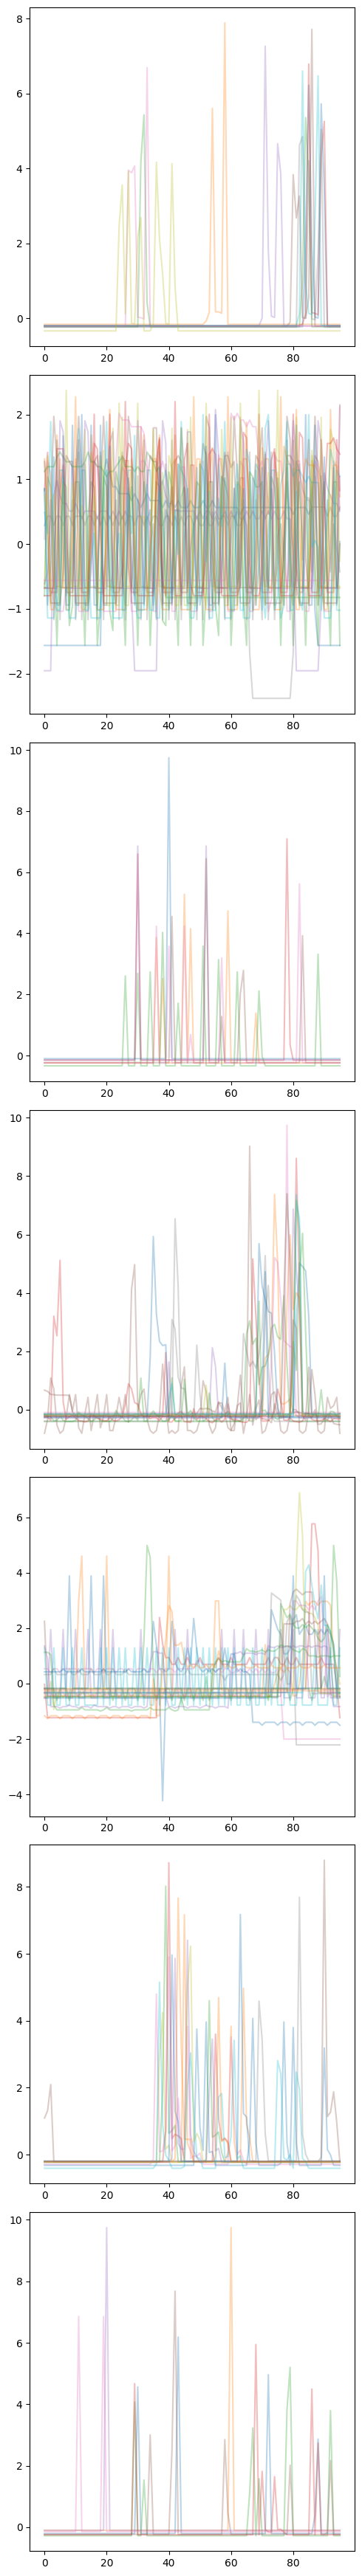

In [44]:
labels = np.unique(Y)
f, a = plt.subplots(len(labels), 1, figsize=(5, 5*len(labels)))

# Sample from X
n_samples = 100
samples = np.random.choice(np.arange(len(X)), n_samples)
X_samples = X[samples]
Y_samples = Y[samples]

for i in range(int(len(X_samples))):
    x, y = X_samples[i], Y_samples[i]

    a[y][0].plot(x, alpha=0.3)

plt.tight_layout()
plt.show()

In [85]:
from evaluation.model_eval import Evaluation
import os
import re
from collections import defaultdict
from sklearn.manifold import TSNE


In [80]:
directory = 'saved_models/'

def relevant_model(model_name):
    parts = model_name.split('-')
    #Get maskgits
    relevant = 'maskgit' in parts
        
    # dont include decorr
    relevant &= 'decorr' not in parts

    return relevant



def search_relevant_ids(config):

    def is_relevant(model_name, dataset_name, seed, method):
        parts = model_name.split('-')
        #Get maskgits
        relevant = 'maskgit' in parts
        
        # dont include decorr
        relevant &= 'decorr' not in parts

        relevant &= dataset_name == parts[-1][:-5] #len(.ckpt) = 5
        relevant &= seed == parts[-3]

        return relevant


    dataset_name = config["dataset"]["dataset_name"]
    seed = config["seed"]
    method = config["SSL"]["stage1_method"]

    ids = []
    for model_name in os.listdir("saved_models"):
        if not relevant_model(model_name): continue

        parts = model_name.split('-')
        if dataset_name != parts[-1][:-5]: continue
        if seed != parts[-3]: continue


        if method != "":
            if method != parts[-4]: continue
        ids.append(parts[-2])

    return ids

def group_relevants_by_datasets(list_dirs):
    data = defaultdict(list)
    for model_name in list_dirs:
        if not relevant_model(model_name): continue
        dataset_name = model_name.split('-')[-1][:-5] #len(.ckpt) = 5
        data[dataset_name].append(model_name)
    return data

def fill_config(model_name):
    parts = model_name.split('-')

    config_dir = get_root_dir().joinpath("configs", "config_empty.yaml")
    config = load_yaml_param_settings(config_dir)
    c = config.copy()

    method = ""
    if 'barlowtwins' in parts:
        method = 'barlow_twins'
    elif 'vibcreg' in parts:
        method = 'vibcreg'
    
    c["SSL"]["stage1_method"] = method

    c["dataset"]["dataset_name"] = parts[-1][:-5] #len(.ckpt) = 5
    
    c["seed"] = parts[-3] #search for single index. Equals seed
    
    c["ID"] =  parts[-2]

    return c

def train_and_predict(x_gen, x_test, y):
    


def test_saved_models(directiory, gpu_device_index):

    data = group_relevants_by_datasets(os.listdir(directiory))
    config_dir = get_root_dir().joinpath("configs", "config_empty.yaml")
    c = load_yaml_param_settings(config_dir)

    for dataset_name in data.keys:
        c['dataset']['dataset_name'] = dataset_name

        dataset_importer = UCRDatasetImporter(**c["dataset"])

        evaluation = Evaluation(
            subset_dataset_name=dataset_name,
            gpu_device_index=gpu_device_index,
            config=c,
            batch_size=c["dataset"]["batch_sizes"]["stage2"]
        )

        for model_name in data[dataset_name]:

            n_classes = len(np.unique(dataset_importer.Y))
            input_length = len(dataset_importer.X_train[0])

            c = fill_config(model_name)
            #prodeed on regular version:
            if c["SSL"]["stage1_method"] == "":
                n_samples =  max(evaluation.X_test[0], config["dataset"]["batch_sizes"]["stage2"])
                unconditional_gen = evaluation.sampleMaskGit(
                    n_samples,
                    input_length,
                    n_classes,
                    "unconditional",
                )

                for c in range(n_classes):
                    cond_gen = evaluation.sampleMaskGit(
                        n_samples,
                        input_length,
                        n_classes,
                        "conditional",
                        class_index=c
                    )
                    evaluation.log_tsne(
                        1000,
                        cond_gen,
                    )
                    
            
                

                


c = fill_config("barlowtwins-decoder-seed-4-A2MFQQR-ShapesAll.ckpt")
#test_saved_models()

#print(c)

data = group_relevants_by_datasets(os.listdir('saved_models'))


In [82]:
data['ShapesAll']

['vibcreg-fullembed-maskgit-seed-1-E8X7ID-ShapesAll.ckpt',
 'barlowtwins-fullembed-maskgit-seed-4-EDOMHP-ShapesAll.ckpt',
 'vibcreg-fullembed-maskgit-seed-4-LPCPWZ-ShapesAll.ckpt',
 'vibcreg-fullembed-maskgit-finetuned-seed-1-CX1IDP-ShapesAll.ckpt',
 'vibcreg-fullembed-maskgit-seed-1-CX1IDP-ShapesAll.ckpt',
 'vibcreg-fullembed-maskgit-seed-4-1IKCHM-ShapesAll.ckpt',
 'maskgit-seed-1-A2MFQR-ShapesAll.ckpt',
 'barlowtwins-fullembed-maskgit-seed-1-A2MFQR-ShapesAll.ckpt',
 'vibcreg-fullembed-maskgit-seed-4-EDOMHP-ShapesAll.ckpt',
 'vibcreg-fullembed-maskgit-seed-1-A2MFQR-ShapesAll.ckpt',
 'vibcreg-fullembed-maskgit-finetuned-seed-4-LPCPWZ-ShapesAll.ckpt',
 'vibcreg-fullembed-maskgit-seed-4-CRGQ22-ShapesAll.ckpt',
 'maskgit-seed-4-EDOMHP-ShapesAll.ckpt',
 'vibcreg-fullembed-maskgit-seed-1-QKOP2H-ShapesAll.ckpt']